In [25]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.util import flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [26]:
data = pd.read_json("top100.json")
data = data['_via_img_metadata'].dropna().reset_index()

In [27]:
data["width"] = data["_via_img_metadata"].apply(lambda x: re.findall(r"width\W*(\d+)",str(x)))
data["height"] = data["_via_img_metadata"].apply(lambda x: re.findall(r"height\W*(\d+)",str(x)))

In [28]:
data["x"] = data["_via_img_metadata"].apply(lambda x: re.findall(r"\'x\'\W*(\d+)",str(x)))
data["y"] = data["_via_img_metadata"].apply(lambda x: re.findall(r"\'y\'\W*(\d+)",str(x)))

In [29]:
data['_via_img_metadata'][5]

{'filename': 'img_006.jpg',
 'size': 58001,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 164,
    'y': 48,
    'width': 90,
    'height': 170},
   'region_attributes': {'Face': 'Front'}},
  {'shape_attributes': {'name': 'rect',
    'x': 18,
    'y': 12,
    'width': 62,
    'height': 96},
   'region_attributes': {'Face': 'Left'}}],
 'file_attributes': {'Face': 'Front'}}

In [30]:
df = pd.DataFrame({
    'width' : flatten(data["width"].tolist()),
    'height' : flatten(data["height"].tolist()),
    'xmin' : flatten(data["x"].tolist()) ,
    'ymin' : flatten(data["y"].tolist())
})

x_max = x + width

y_max = y + height

In [7]:
df.head()

,width,height,xmin,ymin
0,41,92,277,56
1,77,135,86,16
2,60,116,182,7
3,55,107,241,17
4,68,93,198,5


In [8]:
for i in df.columns:
    df[i] = pd.to_numeric(df[i])

In [9]:
# df['xmax'] = df['xmin'].map(int) + df['width'].map(int)
# df['ymax'] = df['ymin'].map(int) + df['height'].map(int)
# df['xmax_xmin'] =  df['xmax'] - df['xmin']
# df['ymax_ymin'] = df['ymax'] - df['ymin']
df.head()
data = np.array(df[['width', 'height']])

In [10]:
data.shape

(126, 2)

In [11]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


In [12]:
def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [13]:
out = kmeans(data, k=4)
print("Accuracy: {:.2f}%".format(avg_iou(data, out) * 100))
print("Boxes:\n {}".format(out))

ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
print("Ratios:\n {}".format(sorted(ratios)))

Accuracy: 77.76%
Boxes:
 [[116 254]
 [ 67 127]
 [ 42  78]
 [ 91 176]]
Ratios:
 [0.46, 0.52, 0.53, 0.54]


# Using sklearn

In [31]:
# df = pd.DataFrame({
#     'x': [12, 20, 28, 18, 29, 33, 24, 45, 45, 52, 51, 52, 55, 53, 55, 61, 64, 69, 72],
#     'y': [39, 36, 30, 52, 54, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14, 8, 19, 7, 24]
# })

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [32]:
labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_
colmap = {1: 'r', 2: 'g', 3: 'b', 4:'black'}

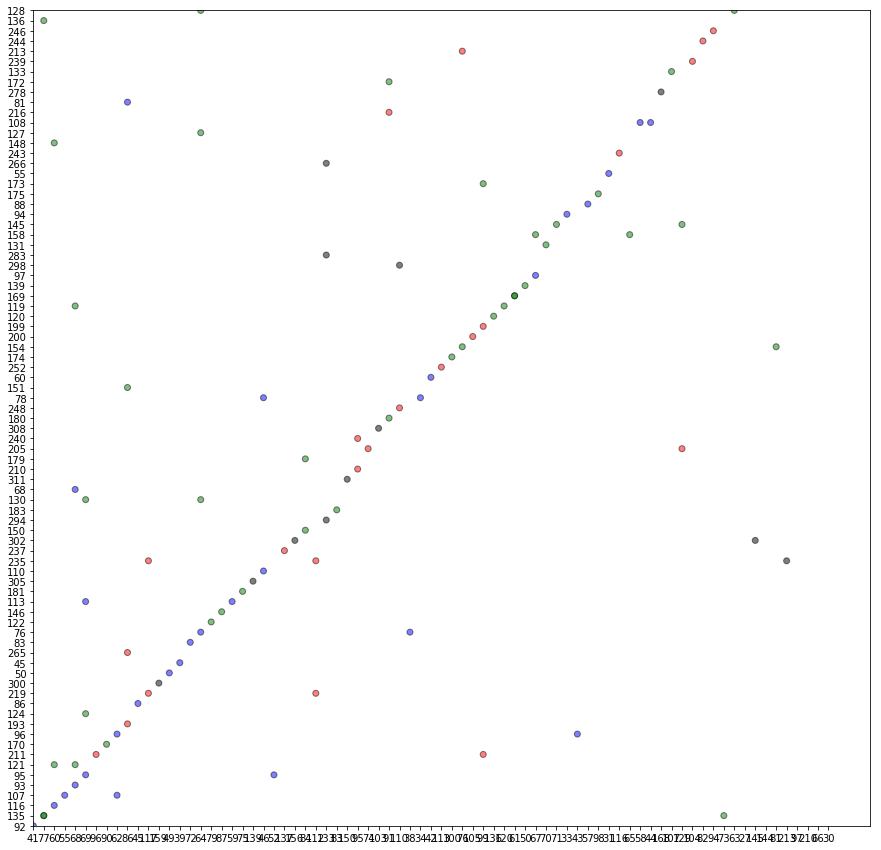

In [44]:
fig = plt.figure(figsize=(15, 15))

colors = list(map(lambda x: colmap[x+1], labels))

plt.scatter(df["width"],df['height'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])
plt.xlim(0, 80)
plt.ylim(0, 80)
# plt.show()
plt.savefig('k-mean.png')